In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
pd.set_option('display.max_rows', 500)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as datetime
import itertools
import warnings
from statsmodels.tsa.arima_model import ARIMA

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [4]:
# pearson correlation coefficient
def compute_covariance(x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    l = len(x)
    return np.sum((x - mean_x)*(y-mean_y))/(std_x*std_y*l)

In [5]:
features_data = pd.read_csv("dengue_features_train.csv")
labels_data = pd.read_csv("dengue_labels_train.csv")
data = pd.merge(features_data, labels_data, on=['city','year','weekofyear']) # merging features and labels
sj_data = data[data["city"]=="sj"].reset_index(drop=True) # filtering sj city data
iq_data = data[data["city"]=="iq"].reset_index(drop=True) # filtering sj city data

del features_data, labels_data, data
target = 'total_cases'
features_list = [feature for feature in sj_data.columns if feature != target] 

In [6]:
sj_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [7]:
iq_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


# Univariate Time Series Model on Weekly Data for San Juan

### Note the week are not periodic, every year the week starts from 1st date of the year

In [145]:
# ts_data = sj_data[(sj_data['year'] > 1990) & (sj_data['year'] < 2008)][['week_start_date', 'total_cases']].reset_index(drop=True)
ts_data = sj_data[['week_start_date', 'total_cases']].copy()
ts_data["week_start_date"] = dates_from_str(ts_data['week_start_date'])
ts_data.set_index('week_start_date', inplace=True)

In [146]:
ts_data.head()

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6


In [147]:
pd.infer_freq(ts_data.index)

In [148]:
ts_data.index.year

Int64Index([1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990,
            ...
            2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008],
           dtype='int64', name='week_start_date', length=936)

Text(0.5, 1.0, 'San Juan')

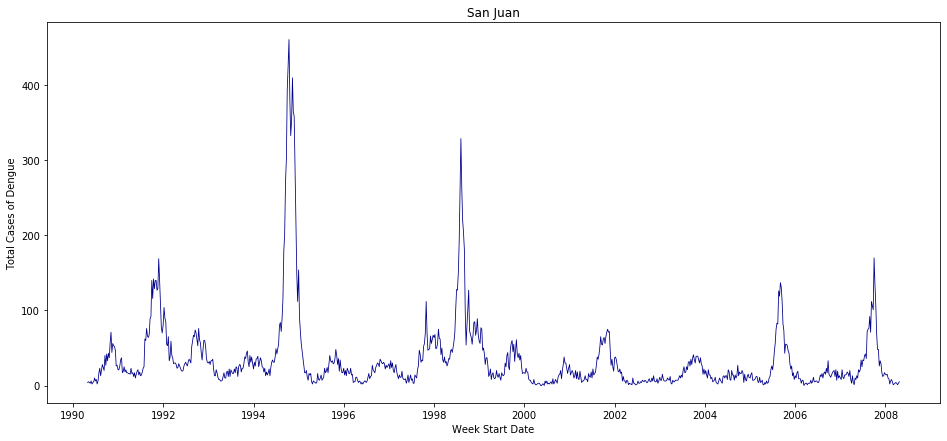

In [149]:
plt.figure(figsize=(16,7))
plt.plot(ts_data, color="darkblue", linewidth=.8)
plt.xlabel("Week Start Date")
plt.ylabel("Total Cases of Dengue")
plt.title("San Juan")
# plt.savefig("San Juan Dengue Cases by Week of Year.png")

#### ACF gives autocorrelation(correlation coefficient) between y and shifted y 

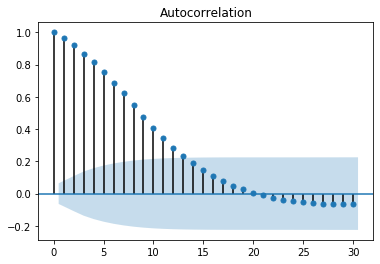

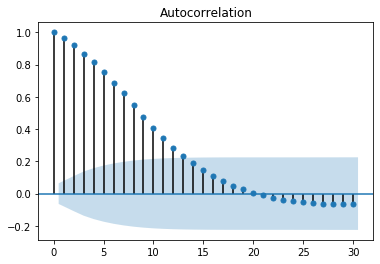

In [150]:
plot_acf(ts_data)

In [151]:
# computing variance indicating ACF
eda_ts = ts_data.copy()
shift = 13
eda_ts['shift'+str(shift)] = eda_ts.shift(shift)
eda_ts.dropna(inplace=True)
eda_ts.head()
compute_covariance(x=eda_ts['total_cases'], y = eda_ts['shift'+str(shift)])

0.23285224943845023

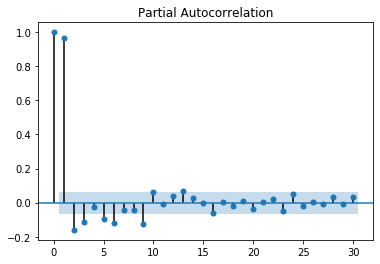

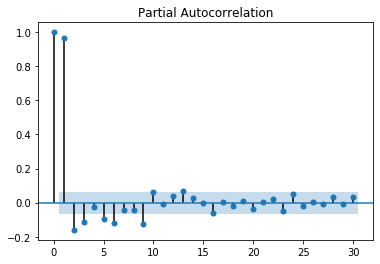

In [152]:
plot_pacf(ts_data)

## p,d and q 
1. p is auto regressive part
2. d stands for differencing, used in time series with trend, necessary to remove the trend to make time series stationary, as all time series are based on assumption that time series is stationary
3. q is for moving average

### ARIMA Model for Univariate Time Series Model on Weekly Data Without Train Data Updation on San Juan

In [153]:
X = ts_data.values
size = int(len(X) * 0.855)
train, test_actual = X[0:size], X[size:len(X)]
print("train size: %f, test size: %f, total size %f: "%(len(train), len(test_actual), len(ts_data)))

train = [x for x in train] # creating list of training data, just to make it model usable
test_pred = [] # creating list to store new prediction for test set
conf_int_low = []
conf_int_high = []
for t in range(len(test_actual)):
    model = ARIMA(train, order=(2,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1) # next week forecast
    yhat = output[0] # next week prediction 
    conf_int_low.append(output[2][0][0]) # adding low range of confidence interval
    conf_int_high.append(output[2][0][1]) # adding upper range of confidene interval
    test_pred.append(yhat) # adding single week prediction
    train.append(yhat) # adding what was predicted by the model to train set to make next prediction 
    print('iteration :%s, predicted=%f, actual=%f' % (t+1, test_pred[t], test_actual[t]))

train size: 800.000000, test size: 136.000000, total size 936.000000: 
iteration :1, predicted=130.003034, actual=112.000000
iteration :2, predicted=127.779059, actual=82.000000
iteration :3, predicted=124.525949, actual=73.000000
iteration :4, predicted=120.429816, actual=43.000000
iteration :5, predicted=115.664052, actual=55.000000
iteration :6, predicted=110.388294, actual=55.000000
iteration :7, predicted=104.748374, actual=53.000000
iteration :8, predicted=98.875573, actual=46.000000
iteration :9, predicted=92.886864, actual=43.000000
iteration :10, predicted=86.885232, actual=29.000000
iteration :11, predicted=80.959908, actual=22.000000
iteration :12, predicted=75.187044, actual=26.000000
iteration :13, predicted=69.630286, actual=13.000000
iteration :14, predicted=64.341371, actual=17.000000
iteration :15, predicted=59.361455, actual=8.000000
iteration :16, predicted=54.721420, actual=13.000000
iteration :17, predicted=50.443304, actual=10.000000
iteration :18, predicted=46.54

In [154]:
mse_error = mean_squared_error(test_actual, test_pred)
mae_error = mean_absolute_error(test_actual, test_pred)
print('Test Square MSE: %.3f and Test Absolute MAE: %.3f'% (mse_error, mae_error))

Test Square MSE: 1211.609 and Test Absolute MAE: 29.698


In [155]:
# plot
test_actual = pd.DataFrame(data=test_actual, index=ts_data[size:].index)
test_pred = pd.DataFrame(data=test_pred, index=ts_data[size:].index)
conf_int_low = pd.DataFrame(data=conf_int_low, index=ts_data[size:].index)
conf_int_high = pd.DataFrame(data=conf_int_high, index=ts_data[size:].index)

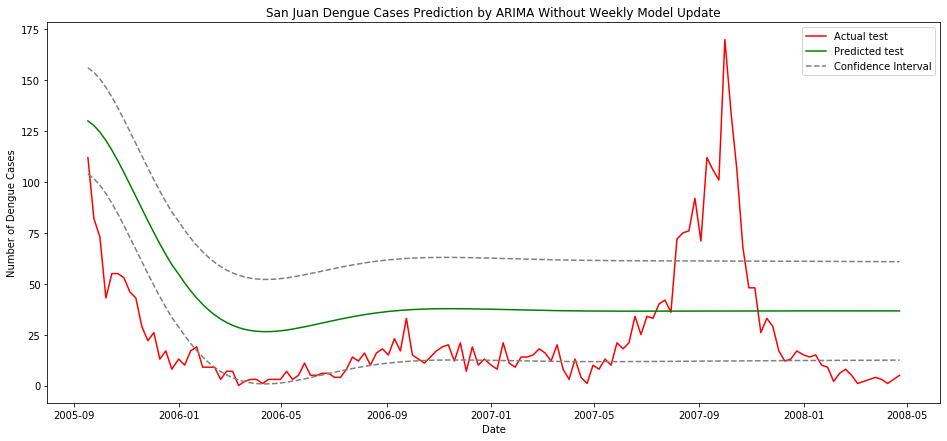

In [157]:
plt.figure(figsize=(16,7))
plt.plot(test_actual, color='red', label="Actual test")
plt.plot(test_pred, color='green', label="Predicted test")
plt.plot(conf_int_low, '--', color='grey', label="Confidence Interval")
plt.plot(conf_int_high, '--', color='grey')
plt.legend()
plt.title("San Juan Dengue Cases Prediction by ARIMA Without Weekly Model Update")
plt.ylabel("Number of Dengue Cases")
plt.xlabel("Date")
plt.savefig("ArimaPredictionWithoutUpdation_SJ.png")
plt.show()

### ARIMA Model for Univariate Time Series Model on Weekly Data With Train Data Updation on San Juan

In [159]:
X = ts_data.values
size = int(len(X) * 0.855)
train, test_actual = X[0:size], X[size:len(X)]
print("train size: %f, test size: %f, total size %f: "%(len(train), len(test_actual), len(ts_data)))

train = [x for x in train] # creating list of training data, just to make it model usable
test_pred = [] # creating list to store new prediction for test set
conf_int_low = []
conf_int_high = []
for t in range(len(test_actual)):
    model = ARIMA(train, order=(2,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1) # next week forecast
    yhat = output[0] # next week prediction 
    conf_int_low.append(output[2][0][0]) # adding low range of confidence interval
    conf_int_high.append(output[2][0][1]) # adding upper range of confidene interval
    test_pred.append(yhat) # adding single week prediction
    train.append(test_actual[t]) # adding actual test value to train set to make next prediction 
    print('iteration :%s, predicted=%f, actual=%f' % (t+1, test_pred[t], test_actual[t]))

train size: 800.000000, test size: 136.000000, total size 936.000000: 
iteration :1, predicted=130.003034, actual=112.000000
iteration :2, predicted=108.204438, actual=82.000000
iteration :3, predicted=75.306399, actual=73.000000
iteration :4, predicted=66.439237, actual=43.000000
iteration :5, predicted=34.743819, actual=55.000000
iteration :6, predicted=49.786097, actual=55.000000
iteration :7, predicted=50.762327, actual=53.000000
iteration :8, predicted=49.331423, actual=46.000000
iteration :9, predicted=42.367988, actual=43.000000
iteration :10, predicted=39.841722, actual=29.000000
iteration :11, predicted=25.312966, actual=22.000000
iteration :12, predicted=18.715235, actual=26.000000
iteration :13, predicted=24.060127, actual=13.000000
iteration :14, predicted=10.580016, actual=17.000000
iteration :15, predicted=15.846514, actual=8.000000
iteration :16, predicted=6.653378, actual=13.000000
iteration :17, predicted=12.817368, actual=10.000000
iteration :18, predicted=9.956243, a

In [160]:
mse_error = mean_squared_error(test_actual, test_pred)
mae_error = mean_absolute_error(test_actual, test_pred)
print('Test Square MSE: %.3f and Test Absolute MAE: %.3f'% (mse_error, mae_error))

Test Square MSE: 140.523 and Test Absolute MAE: 7.190


In [161]:
# plot
test_actual = pd.DataFrame(data=test_actual, index=ts_data[size:].index)
test_pred = pd.DataFrame(data=test_pred, index=ts_data[size:].index)
conf_int_low = pd.DataFrame(data=conf_int_low, index=ts_data[size:].index)
conf_int_high = pd.DataFrame(data=conf_int_high, index=ts_data[size:].index)

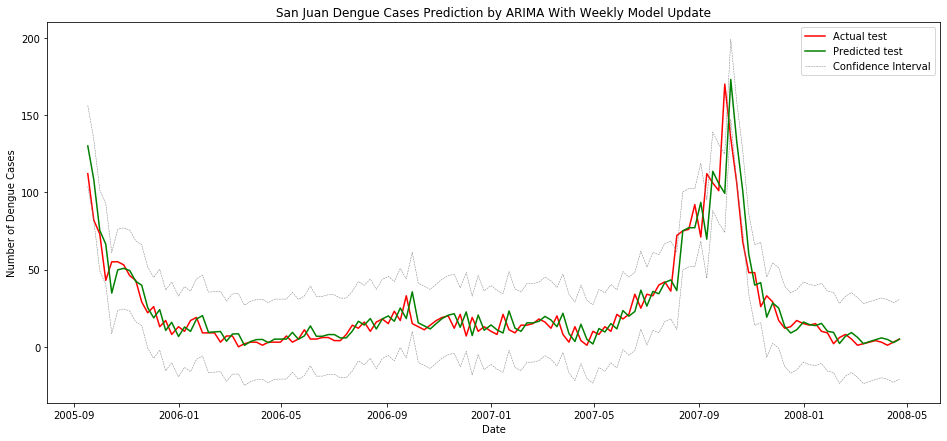

In [162]:
plt.figure(figsize=(16,7))
plt.plot(test_actual, color='red', label="Actual test")
plt.plot(test_pred, color='green', label="Predicted test")
plt.plot(conf_int_low, '--', linewidth = .5, color='grey', label="Confidence Interval")
plt.plot(conf_int_high, '--', linewidth = .5, color='grey')
plt.legend()
plt.title("San Juan Dengue Cases Prediction by ARIMA With Weekly Model Update")
plt.ylabel("Number of Dengue Cases")
plt.xlabel("Date")
plt.savefig("ArimaPredictionWithUpdation_SJ.png")
plt.show()

# Univariate Time Series Model on Weekly Data for Iquitos

### Note the week are not periodic, every year the week starts from 1st date of the year

In [163]:
# ts_data = sj_data[(sj_data['year'] > 1990) & (sj_data['year'] < 2008)][['week_start_date', 'total_cases']].reset_index(drop=True)
ts_data = iq_data[['week_start_date', 'total_cases']].copy()
ts_data["week_start_date"] = dates_from_str(ts_data['week_start_date'])
ts_data.set_index('week_start_date', inplace=True)

In [164]:
ts_data.head()

,total_cases
week_start_date,
2000-07-01,0
2000-07-08,0
2000-07-15,0
2000-07-22,0
2000-07-29,0


In [165]:
pd.infer_freq(ts_data.index)

Text(0.5, 1.0, 'Iquitos')

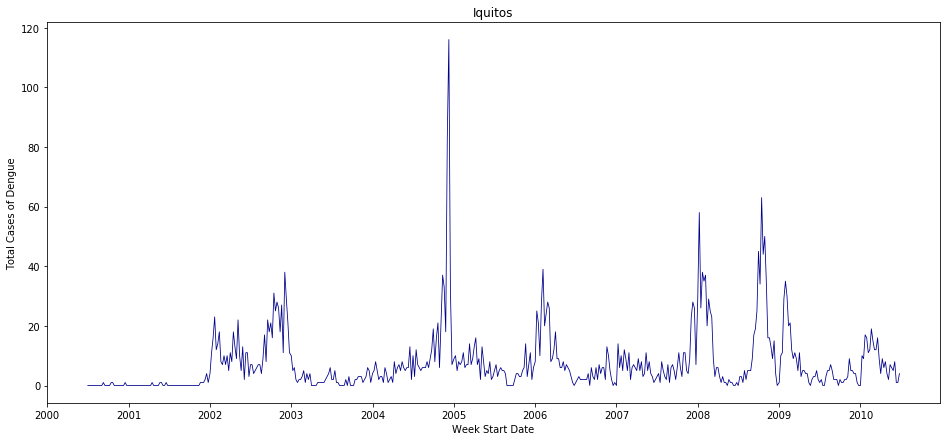

In [166]:
plt.figure(figsize=(16,7))
plt.plot(ts_data, color="darkblue", linewidth=.8)
plt.xlabel("Week Start Date")
plt.ylabel("Total Cases of Dengue")
plt.title("Iquitos")
# plt.savefig("Iquitos Dengue Cases by Week of Year.png")

#### ACF gives autocorrelation(correlation coefficient) between y and shifted y 

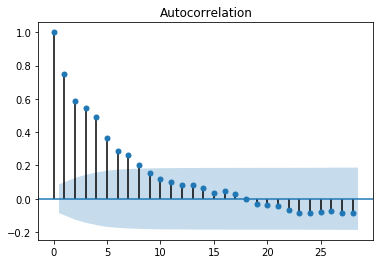

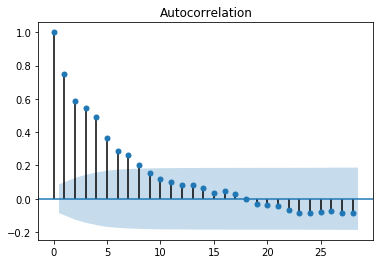

In [167]:
plot_acf(ts_data)

In [168]:
# computing variance indicating ACF
eda_ts = ts_data.copy()
shift = 13
eda_ts['shift'+str(shift)] = eda_ts.shift(shift)
eda_ts.dropna(inplace=True)
eda_ts.head()
compute_covariance(x=eda_ts['total_cases'], y = eda_ts['shift'+str(shift)])

0.0830243714027826

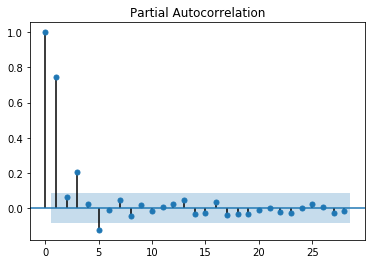

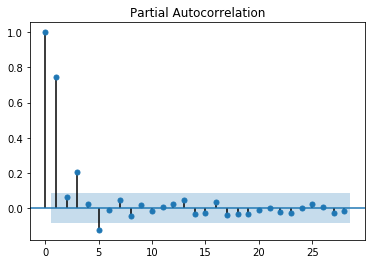

In [169]:
plot_pacf(ts_data)

### ARIMA Model for Univariate Time Series Model on Weekly Data Without Train Data Updation on Iquitos

In [170]:
X = ts_data.values
size = int(len(X) * 0.855)
train, test_actual = X[0:size], X[size:len(X)]
print("train size: %f, test size: %f, total size %f: "%(len(train), len(test_actual), len(ts_data)))

train = [x for x in train] # creating list of training data, just to make it model usable
test_pred = [] # creating list to store new prediction for test set
conf_int_low = []
conf_int_high = []
for t in range(len(test_actual)):
    model = ARIMA(train, order=(2,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1) # next week forecast
    yhat = output[0] # next week prediction 
    conf_int_low.append(output[2][0][0]) # adding low range of confidence interval
    conf_int_high.append(output[2][0][1]) # adding upper range of confidene interval
    test_pred.append(yhat) # adding single week prediction
    train.append(yhat) # adding what was predicted by the model to train set to make next prediction 
    print('iteration :%s, predicted=%f, actual=%f' % (t+1, test_pred[t], test_actual[t]))

train size: 444.000000, test size: 76.000000, total size 520.000000: 
iteration :1, predicted=8.416035, actual=11.000000
iteration :2, predicted=7.908266, actual=29.000000
iteration :3, predicted=7.738704, actual=35.000000
iteration :4, predicted=7.676317, actual=30.000000
iteration :5, predicted=7.648658, actual=20.000000
iteration :6, predicted=7.632919, actual=21.000000
iteration :7, predicted=7.621816, actual=12.000000
iteration :8, predicted=7.612966, actual=9.000000
iteration :9, predicted=7.605514, actual=11.000000
iteration :10, predicted=7.599108, actual=9.000000
iteration :11, predicted=7.593555, actual=5.000000
iteration :12, predicted=7.588716, actual=11.000000
iteration :13, predicted=7.584512, actual=3.000000
iteration :14, predicted=7.580852, actual=5.000000
iteration :15, predicted=7.577669, actual=5.000000
iteration :16, predicted=7.574885, actual=4.000000
iteration :17, predicted=7.572465, actual=4.000000
iteration :18, predicted=7.570362, actual=1.000000
iteration :1

In [171]:
mse_error = mean_squared_error(test_actual, test_pred)
mae_error = mean_absolute_error(test_actual, test_pred)
print('Test Square MSE: %.3f and Test Absolute MAE: %.3f'% (mse_error, mae_error))

Test Square MSE: 49.893 and Test Absolute MAE: 5.376


In [172]:
# plot
test_actual = pd.DataFrame(data=test_actual, index=ts_data[size:].index)
test_pred = pd.DataFrame(data=test_pred, index=ts_data[size:].index)
conf_int_low = pd.DataFrame(data=conf_int_low, index=ts_data[size:].index)
conf_int_high = pd.DataFrame(data=conf_int_high, index=ts_data[size:].index)

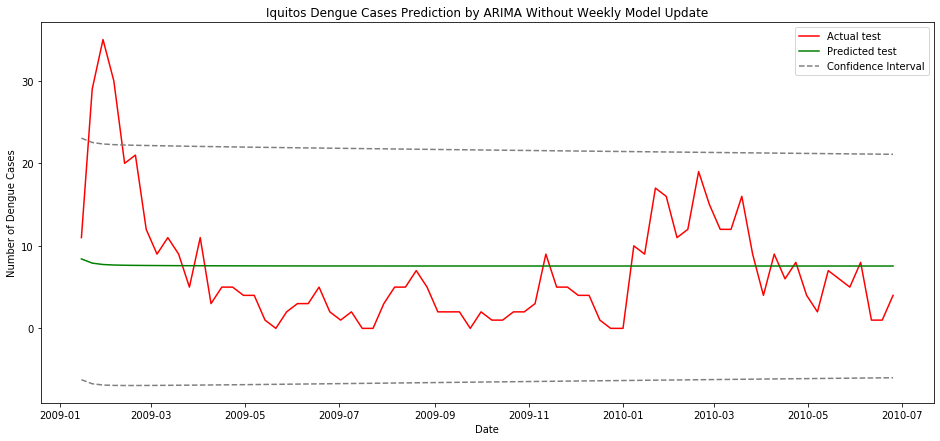

In [173]:
plt.figure(figsize=(16,7))
plt.plot(test_actual, color='red', label="Actual test")
plt.plot(test_pred, color='green', label="Predicted test")
plt.plot(conf_int_low, '--', color='grey', label="Confidence Interval")
plt.plot(conf_int_high, '--', color='grey')
plt.legend()
plt.title("Iquitos Dengue Cases Prediction by ARIMA Without Weekly Model Update")
plt.ylabel("Number of Dengue Cases")
plt.xlabel("Date")
plt.savefig("ArimaPredictionWithoutUpdation_IQ.png")
plt.show()

### ARIMA Model for Univariate Time Series Model on Weekly Data With Train Data Updation on Iquitos

In [174]:
X = ts_data.values
size = int(len(X) * 0.855)
train, test_actual = X[0:size], X[size:len(X)]
print("train size: %f, test size: %f, total size %f: "%(len(train), len(test_actual), len(ts_data)))

train = [x for x in train] # creating list of training data, just to make it model usable
test_pred = [] # creating list to store new prediction for test set
conf_int_low = []
conf_int_high = []
for t in range(len(test_actual)):
    model = ARIMA(train, order=(2,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1) # next week forecast
    yhat = output[0] # next week prediction 
    conf_int_low.append(output[2][0][0]) # adding low range of confidence interval
    conf_int_high.append(output[2][0][1]) # adding upper range of confidene interval
    test_pred.append(yhat) # adding single week prediction
    train.append(test_actual[t]) # adding actual test value to train set to make next prediction 
    print('iteration :%s, predicted=%f, actual=%f' % (t+1, test_pred[t], test_actual[t]))

train size: 444.000000, test size: 76.000000, total size 520.000000: 
iteration :1, predicted=8.416035, actual=11.000000
iteration :2, predicted=9.563131, actual=29.000000
iteration :3, predicted=21.493329, actual=35.000000
iteration :4, predicted=27.060784, actual=30.000000
iteration :5, predicted=25.046395, actual=20.000000
iteration :6, predicted=18.770856, actual=21.000000
iteration :7, predicted=18.945930, actual=12.000000
iteration :8, predicted=12.811993, actual=9.000000
iteration :9, predicted=10.101139, actual=11.000000
iteration :10, predicted=10.817553, actual=9.000000
iteration :11, predicted=9.306296, actual=5.000000
iteration :12, predicted=6.436722, actual=11.000000
iteration :13, predicted=9.967932, actual=3.000000
iteration :14, predicted=4.918791, actual=5.000000
iteration :15, predicted=5.780345, actual=5.000000
iteration :16, predicted=5.673141, actual=4.000000
iteration :17, predicted=4.960471, actual=4.000000
iteration :18, predicted=4.858874, actual=1.000000
iter

In [175]:
mse_error = mean_squared_error(test_actual, test_pred)
mae_error = mean_absolute_error(test_actual, test_pred)
print('Test Square MSE: %.3f and Test Absolute MAE: %.3f'% (mse_error, mae_error))

Test Square MSE: 17.662 and Test Absolute MAE: 2.895


In [176]:
# plot
test_actual = pd.DataFrame(data=test_actual, index=ts_data[size:].index)
test_pred = pd.DataFrame(data=test_pred, index=ts_data[size:].index)
conf_int_low = pd.DataFrame(data=conf_int_low, index=ts_data[size:].index)
conf_int_high = pd.DataFrame(data=conf_int_high, index=ts_data[size:].index)

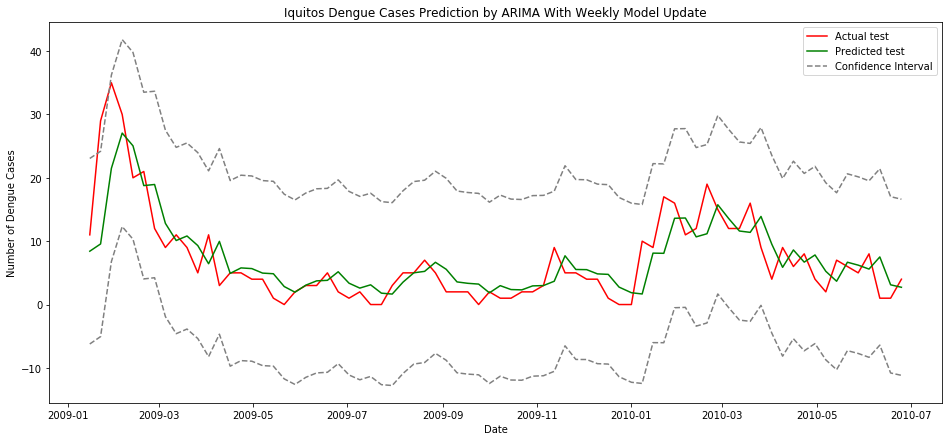

In [177]:
plt.figure(figsize=(16,7))
plt.plot(test_actual, color='red', label="Actual test")
plt.plot(test_pred, color='green', label="Predicted test")
plt.plot(conf_int_low, '--', color='grey', label="Confidence Interval")
plt.plot(conf_int_high, '--', color='grey')
plt.legend()
plt.title("Iquitos Dengue Cases Prediction by ARIMA With Weekly Model Update")
plt.ylabel("Number of Dengue Cases")
plt.xlabel("Date")
plt.savefig("ArimaPredictionWithUpdation_IQ.png")
plt.show()

# Test Run ARIMA

In [251]:
warnings.filterwarnings('ignore')
p=d=q=range(0,3)
pdq = list(itertools.product(p,q,d))
len_pdq = len(pdq)
min_error = 1000000
best_pdq = None
i=0
for param in pdq:
    i+=1
    print("iteration %s out of %s" %(i, len_pdq))
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        error = model_arima_fit.aic
        print("param %s , error %s"%(param, error))
        
        if error < min_error:
            print("updating pdq")
            best_pdq = param
            min_error = error
    except:
        continue   

iteration 1 out of 27
param (0, 0, 0) , error 8656.99298831124
updating pdq
iteration 2 out of 27
param (0, 0, 1) , error 7820.15840272928
updating pdq
iteration 3 out of 27
iteration 4 out of 27
param (0, 1, 0) , error 6475.543570507782
updating pdq
iteration 5 out of 27
param (0, 1, 1) , error 6458.096462351872
updating pdq
iteration 6 out of 27
param (0, 1, 2) , error 6451.541954290706
updating pdq
iteration 7 out of 27
param (0, 2, 0) , error 6873.995812457287
iteration 8 out of 27
param (0, 2, 1) , error 6477.048687344002
iteration 9 out of 27
param (0, 2, 2) , error 6459.3793252727555
iteration 10 out of 27
param (1, 0, 0) , error 6475.83167543437
iteration 11 out of 27
param (1, 0, 1) , error 6454.582836197464
iteration 12 out of 27
param (1, 0, 2) , error 6444.227201999862
updating pdq
iteration 13 out of 27
param (1, 1, 0) , error 6454.49268420861
iteration 14 out of 27
param (1, 1, 1) , error 6450.590490010673
iteration 15 out of 27
param (1, 1, 2) , error 6450.784332797911
i

In [252]:
best_pdq

(2, 0, 1)

In [253]:
# fitting model with best params
model_arima = ARIMA(train, order=best_pdq)
model_arima_fit = model_arima.fit()

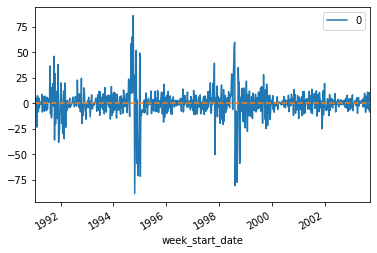

In [254]:
resid = pd.DataFrame(arima_model_fit.resid)
resid.plot()
plt.plot(resid.index,[0.]*len(resid),'--')

In [255]:
resid.describe()

,0
count,661.000000
mean,-0.068755
std,14.546593
min,-88.757004
25%,-5.335785
50%,0.478413
75%,5.693599
max,85.868422


In [256]:
idx

800

In [257]:
len(ts_data)

936

In [235]:
train.head(100)

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6
1990-06-04,2
1990-06-11,4
1990-06-18,5
1990-06-25,10


In [263]:
predict_valid

week_start_date
1991-01-15   -0.000237
1991-01-22   -1.544208
1991-01-29   -1.751625
1991-02-05    0.997895
1991-02-12    8.799255
1991-02-19   -3.920114
1991-02-26   -3.263832
1991-03-05    3.211413
1991-03-12   -2.146892
dtype: float64

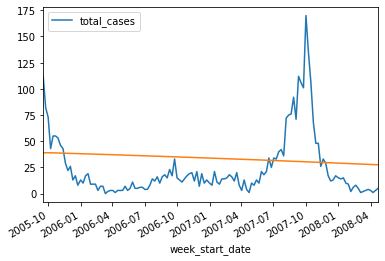

In [205]:
valid.plot()
plt.plot(valid.index,predict)


fig = plt.figure(figsize=(16,7))
plt.plot(['ds'], forecast_train['yhat'], label = 'Predicted train')
plt.plot(train_sj['ds'], train_sj['y'], label = 'Actual train')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label = 'Predicted test')
plt.plot(test_sj['ds'], test_sj['y'], label = 'Actual test')
plt.legend()

In [206]:
plt.savefig("Arima_sj.png")

<Figure size 432x288 with 0 Axes>

### Problem with above model is time series not weekly correctly, we can resolve this by converting weeks into monthly

# Univariate Time Series Model on Monthly Data

In [61]:
ts_data = sj_data[(sj_data['year'] > 1990) & (sj_data['year'] < 2008)][['week_start_date', 'year', 'total_cases']].reset_index(drop=True)
ts_data["week_start_date"] = dates_from_str(ts_data['week_start_date'])

In [62]:
ts_data.dtypes

week_start_date    datetime64[ns]
year                        int64
total_cases                 int64
dtype: object

In [63]:
ts_data['year'] = ts_data['year'].astype(str)
ts_data['month'] = ts_data['week_start_date'].dt.month.astype(str).str.pad(2,'left','0')

In [64]:
ts_data.dtypes

week_start_date    datetime64[ns]
year                       object
total_cases                 int64
month                      object
dtype: object

In [65]:
ts_data.head()

,week_start_date,year,total_cases,month
0,1991-01-01,1991,21,01
1,1991-01-08,1991,21,01
2,1991-01-15,1991,26,01
3,1991-01-22,1991,34,01
4,1991-01-29,1991,37,01


<BarContainer object of 12 artists>

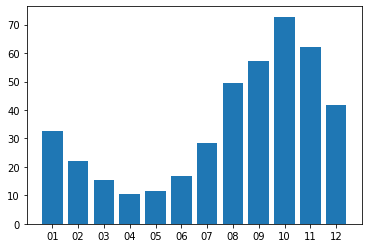

In [66]:
ts_data_m = ts_data.groupby('month').agg({'total_cases':'mean'}).reset_index()
plt.bar(ts_data_m['month'], ts_data_m['total_cases'])

In [67]:
 ts_data['month_start_date'] = ts_data['year'] + '-' + ts_data['month'] + '-01'

In [68]:
ts_data.head()

,week_start_date,year,total_cases,month,month_start_date
0,1991-01-01,1991,21,01,1991-01-01
1,1991-01-08,1991,21,01,1991-01-01
2,1991-01-15,1991,26,01,1991-01-01
3,1991-01-22,1991,34,01,1991-01-01
4,1991-01-29,1991,37,01,1991-01-01


In [69]:
ts_data = ts_data.groupby('month_start_date').agg({'total_cases':'mean'}).reset_index()

In [70]:
ts_data['total_cases'] = ts_data['total_cases'].round()

In [71]:
ts_data.head()

,month_start_date,total_cases
0,1991-01-01,28.0
1,1991-02-01,20.0
2,1991-03-01,18.0
3,1991-04-01,17.0
4,1991-05-01,14.0


In [72]:
len(ts_data)

204

In [73]:
ts_data['month_start_date'] = dates_from_str(ts_data['month_start_date'])
ts_data.set_index('month_start_date', inplace=True)

In [74]:
pd.infer_freq(ts_data.index)

'MS'

In [75]:
ts_data.head()

,total_cases
month_start_date,
1991-01-01,28.0
1991-02-01,20.0
1991-03-01,18.0
1991-04-01,17.0
1991-05-01,14.0


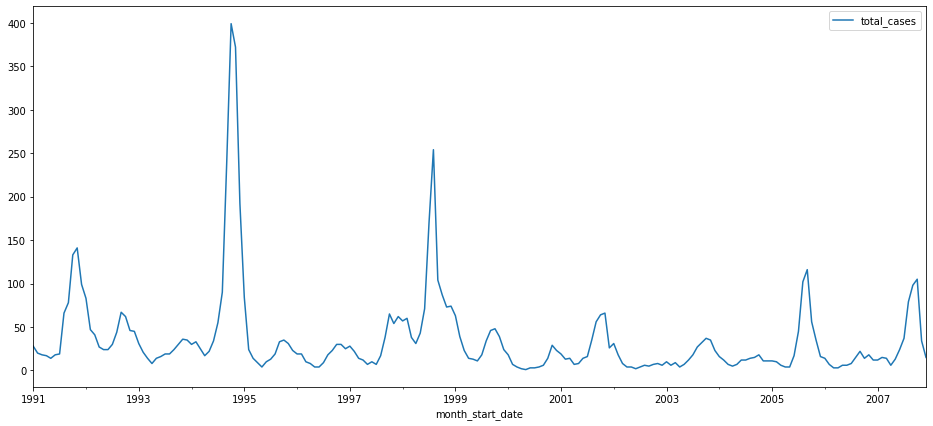

In [76]:
ts_data.plot(figsize=(16,7))

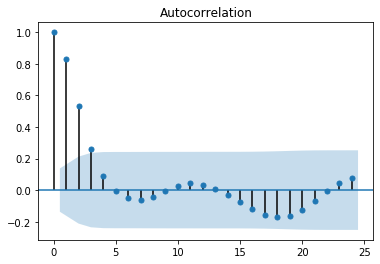

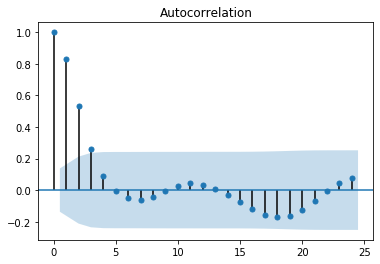

In [77]:
#### ACF gives autocorrelation(correlation coefficient) between y and shifted y 
plot_acf(ts_data)

In [78]:
eda_ts = ts_data.copy()
shift = 3
eda_ts['shift'+str(shift)] = eda_ts.shift(shift)
eda_ts.dropna(inplace=True)
eda_ts.head()
compute_covariance(x=eda_ts['total_cases'], y = eda_ts['shift'+str(shift)])

0.26343911537807896

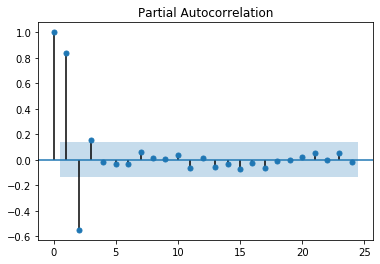

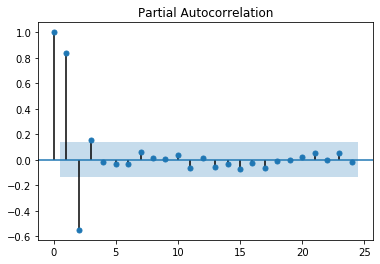

In [79]:
plot_pacf(ts_data)

In [80]:
idx = int(.75*len(ts_data))
train = ts_data[:idx]
valid = ts_data[idx:]

In [81]:
len(ts_data), len(train), len(valid)

(204, 153, 51)

In [86]:
warnings.filterwarnings('ignore')
p=d=q=range(0,4)
pdq = list(itertools.product(p,q,d))
len_pdq = len(pdq)
min_error = 1000000
best_pdq = None
i=0
for param in pdq:
    i+=1
    print("iteration %s out of %s" %(i, len_pdq))
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        error = model_arima_fit.aic
        print("param %s , error %s"%(param, error))
        
        if error < min_error:
            print("updating pdq")
            best_pdq = param
            min_error = error
    except:
        continue   

iteration 1 out of 64
param (0, 0, 0) , error 1669.780722155815
updating pdq
iteration 2 out of 64
param (0, 0, 1) , error 1529.8917871752265
updating pdq
iteration 3 out of 64
iteration 4 out of 64
iteration 5 out of 64
param (0, 1, 0) , error 1491.3437105553285
updating pdq
iteration 6 out of 64
param (0, 1, 1) , error 1456.1645017586377
updating pdq
iteration 7 out of 64
param (0, 1, 2) , error 1457.1732954071306
iteration 8 out of 64
param (0, 1, 3) , error 1456.28235825217
iteration 9 out of 64
param (0, 2, 0) , error 1506.9064267000058
iteration 10 out of 64
param (0, 2, 1) , error 1506.9805746766754
iteration 11 out of 64
param (0, 2, 2) , error 1453.844016013155
updating pdq
iteration 12 out of 64
param (0, 2, 3) , error 1454.6607968681433
iteration 13 out of 64
iteration 14 out of 64
iteration 15 out of 64
iteration 16 out of 64
iteration 17 out of 64
param (1, 0, 0) , error 1490.1572033744237
iteration 18 out of 64
param (1, 0, 1) , error 1446.5543927132335
updating pdq
itera

In [87]:
best_pdq

(3, 1, 1)

In [89]:
# fitting model with best params
model_arima = ARIMA(train, order=best_pdq)
model_arima_fit = model_arima.fit()

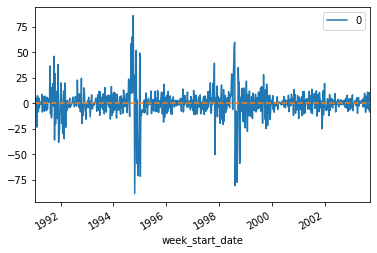

In [90]:
resid = pd.DataFrame(arima_model_fit.resid)
resid.plot()
plt.plot(resid.index,[0.]*len(resid),'--')

In [91]:
resid.describe()

,0
count,661.000000
mean,-0.068755
std,14.546593
min,-88.757004
25%,-5.335785
50%,0.478413
75%,5.693599
max,85.868422


In [92]:
predict = arima_model_fit.forecast(steps=len(valid))[0]
mean_squared_error(y_true=valid.values, y_pred=predict)

946.4144821315999

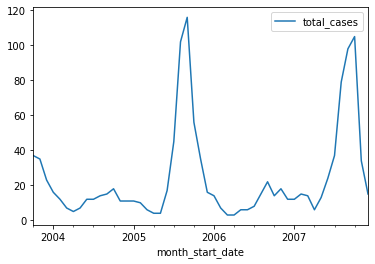

In [93]:
valid.plot()

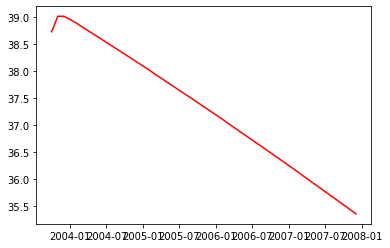

In [94]:
plt.plot(valid.index,predict, color='red')

# Little bit about Stationarity

### The above series is not stationary at all because autocorrelation is decaying very slowly. To apply time series model we need to make series stationary. To do so we will take difference between consecutive values. Selecting no. of difference of days to be taken is called lag.  

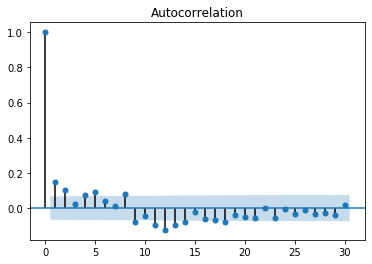

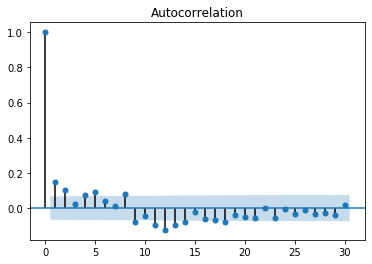

In [238]:
## For ex taking difference by 1 day and again plotting acf, integrated of order 1 
ts_data_d = ts_data.diff(1)
ts_data_d.dropna(inplace=True) # removing na
plot_acf(ts_data_d) ## plotting acf again

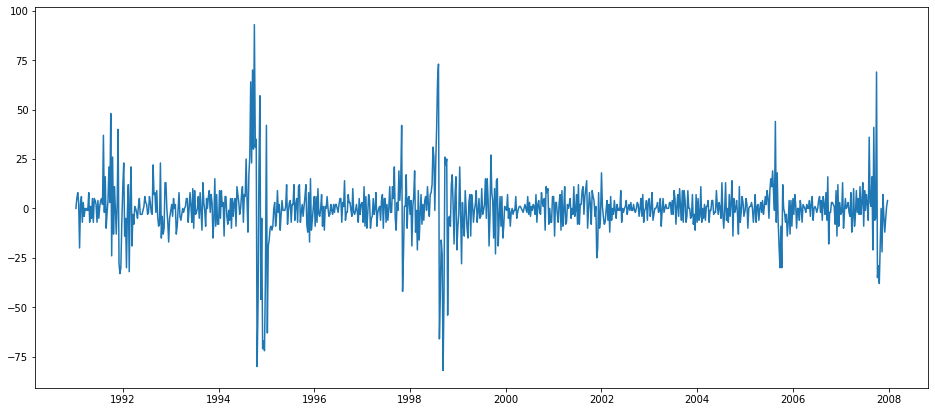

In [264]:
plt.figure(figsize=(16,7))
plt.plot(ts_data_d)

# Univariate Analysis with AR Model using monthly interval data

In [95]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [96]:
len(ts_data), len(train), len(valid)

(204, 153, 51)

In [97]:
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [98]:
predict = model_ar_fit.predict(start=idx, end=len(ts_data)-1)

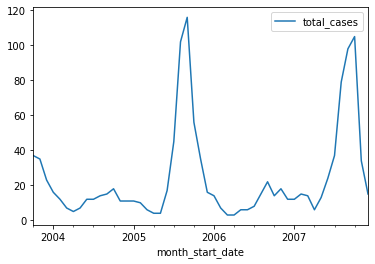

In [99]:
valid.plot()
#plt.plot(valid.index,predict)

In [100]:
len(predict)

51

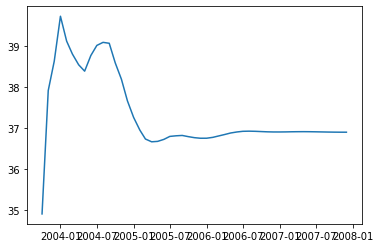

In [101]:
plt.plot(valid.index, predict)

In [102]:
mean_squared_error(y_true=valid.values, y_pred=predict)

942.498166076756

# EDA

In [132]:
ts_data = sj_data[(sj_data['year'] > 1990) & (sj_data['year'] < 2008)][['week_start_date', 'weekofyear',
                                                                        'year', 'total_cases']].reset_index(drop=True)
ts_data["week_start_date"] = dates_from_str(ts_data['week_start_date'])

In [133]:
ts_data.head()

,week_start_date,weekofyear,year,total_cases
0,1991-01-01,1,1991,21
1,1991-01-08,2,1991,21
2,1991-01-15,3,1991,26
3,1991-01-22,4,1991,34
4,1991-01-29,5,1991,37


In [134]:
ts_data['month'] = ts_data['week_start_date'].dt.month.astype(str).str.pad(2,'left','0')
ts_data['weekofyear'] = ts_data['weekofyear'].astype(str).str.pad(2,'left','0')
ts_data['week'] = ts_data['week_start_date'].dt.week.astype(str).str.pad(2,'left','0')

In [136]:
ts_data.head()

,week_start_date,weekofyear,year,total_cases,month,week
0,1991-01-01,01,1991,21,01,01
1,1991-01-08,02,1991,21,01,02
2,1991-01-15,03,1991,26,01,03
3,1991-01-22,04,1991,34,01,04
4,1991-01-29,05,1991,37,01,05


In [139]:
ts_data[ts_data['weekofyear']!=ts_data['week']]

,week_start_date,weekofyear,year,total_cases,month,week


Text(0, 0.5, 'total cases')

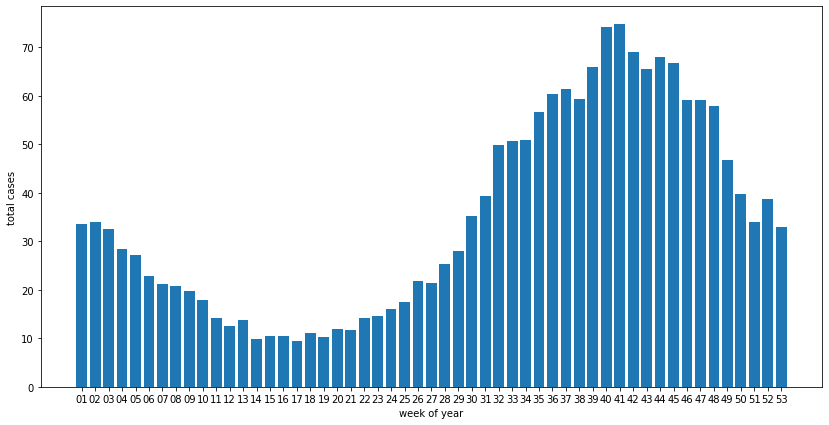

In [142]:
eda_ts = ts_data.groupby(['weekofyear']).agg({'total_cases':'mean'}).reset_index()
plt.figure(figsize=(14,7))
plt.bar(eda_ts['weekofyear'], eda_ts['total_cases'])
plt.xticks(eda_ts['weekofyear'])
plt.xlabel('week of year')
plt.ylabel('total cases')

##### To see yearly trend

Text(0, 0.5, 'total cases')

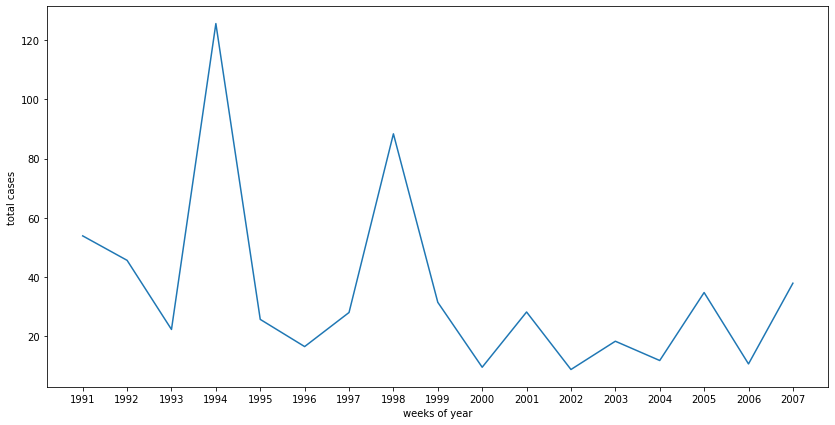

In [143]:
eda_ts = ts_data.groupby('year').agg({'total_cases':'mean'}).reset_index()
plt.figure(figsize=(14,7))
plt.plot(eda_ts['year'],eda_ts['total_cases'])
plt.xticks(eda_ts['year'])
plt.xlabel('weeks of year')
plt.ylabel('total cases')

<Figure size 1008x504 with 0 Axes>

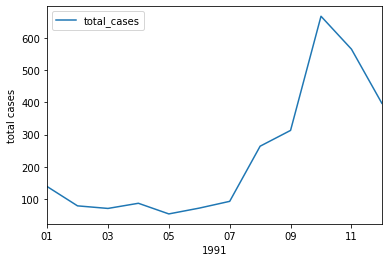

<Figure size 1008x504 with 0 Axes>

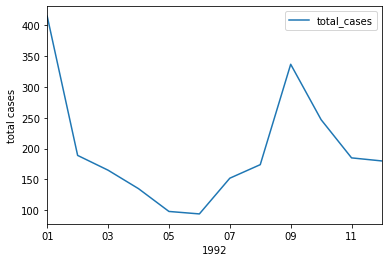

<Figure size 1008x504 with 0 Axes>

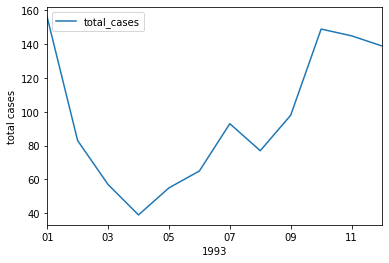

<Figure size 1008x504 with 0 Axes>

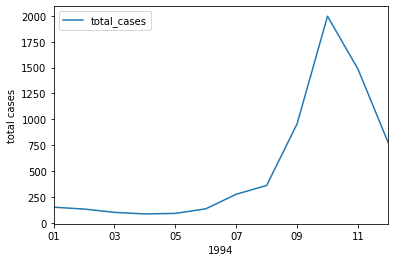

<Figure size 1008x504 with 0 Axes>

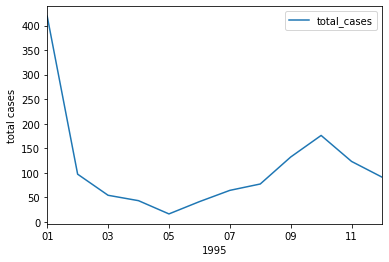

<Figure size 1008x504 with 0 Axes>

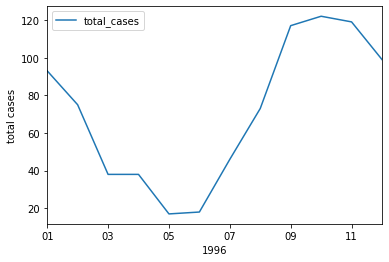

<Figure size 1008x504 with 0 Axes>

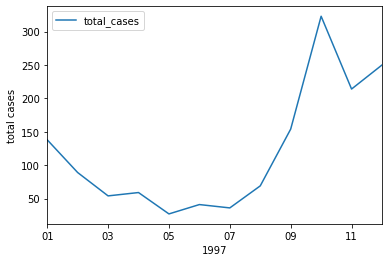

<Figure size 1008x504 with 0 Axes>

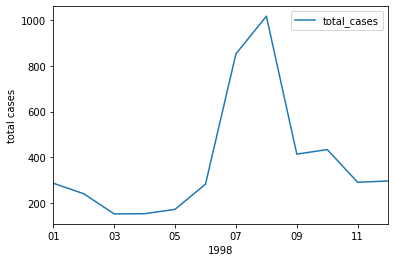

<Figure size 1008x504 with 0 Axes>

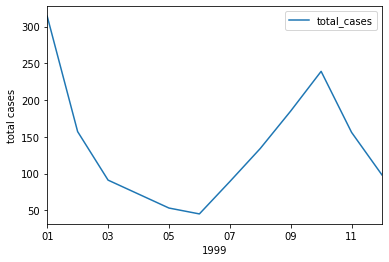

<Figure size 1008x504 with 0 Axes>

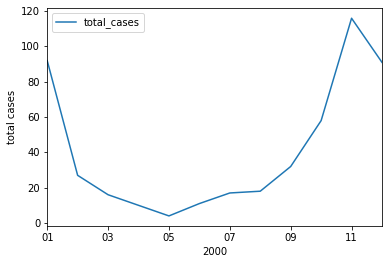

<Figure size 1008x504 with 0 Axes>

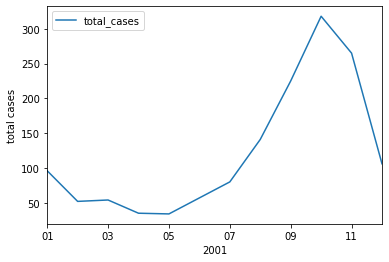

<Figure size 1008x504 with 0 Axes>

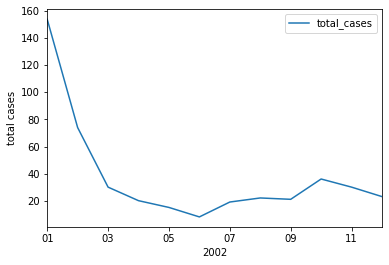

<Figure size 1008x504 with 0 Axes>

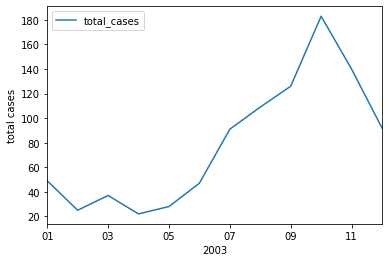

<Figure size 1008x504 with 0 Axes>

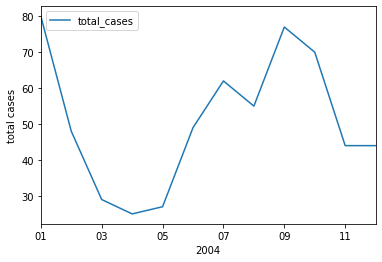

<Figure size 1008x504 with 0 Axes>

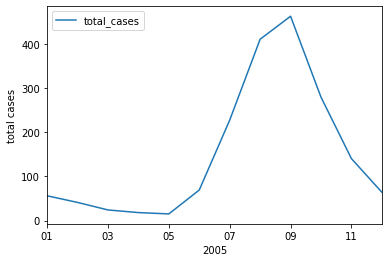

<Figure size 1008x504 with 0 Axes>

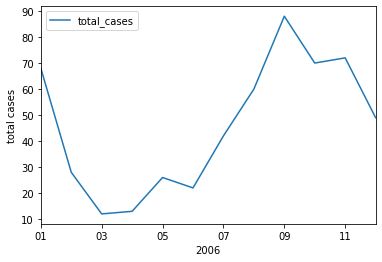

<Figure size 1008x504 with 0 Axes>

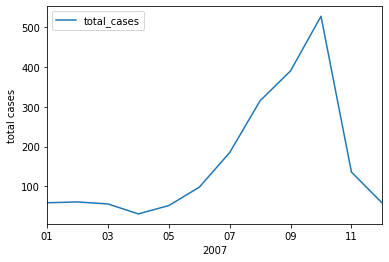

In [144]:
for year in np.unique(ts_data['year']):
    eda_ts = ts_data[ts_data['year']==year][['month','total_cases']]
    eda_ts = eda_ts.groupby('month').agg({'total_cases':'sum'})
    eda_ts.sort_index(inplace=True)
    plt.figure(figsize=(14,7))
    eda_ts.plot()
    plt.xlabel(year)
    plt.ylabel('total cases')

Text(0, 0.5, 'total cases')

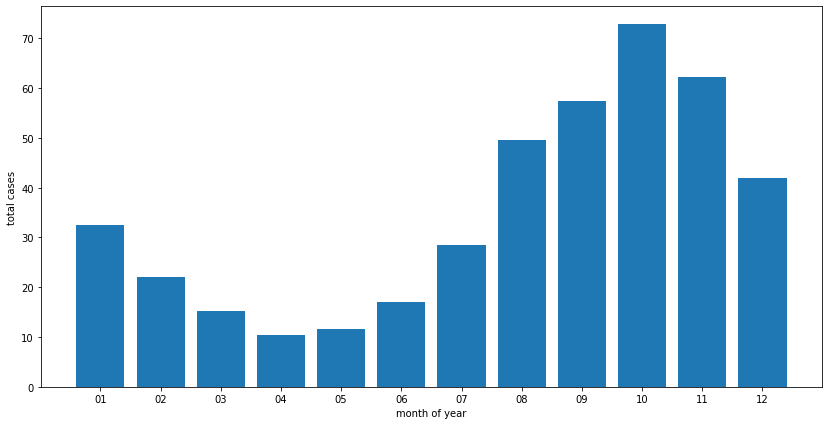

In [145]:
eda_ts = ts_data.groupby(['month']).agg({'total_cases':'mean'}).reset_index()
plt.figure(figsize=(14,7))
plt.bar(eda_ts['month'], eda_ts['total_cases'])
plt.xticks(eda_ts['month'])
plt.xlabel('month of year')
plt.ylabel('total cases')

In [718]:
ts_data = sj_data.copy()
ts_data['month'] = pd.to_datetime(ts_data['week_start_date']).dt.month
ts_data = ts_data[['year', 'month', 'total_cases']]
ts_data = ts_data.groupby(['year','month'], as_index=False).mean()
ts_data['day'] = 1
ts_data['date'] = pd.to_datetime(ts_data[['year','month','day']]).dt.date
ts_data.set_index('date', inplace=True)
ts_data.drop(['year','month','day'], axis=1,inplace=True)

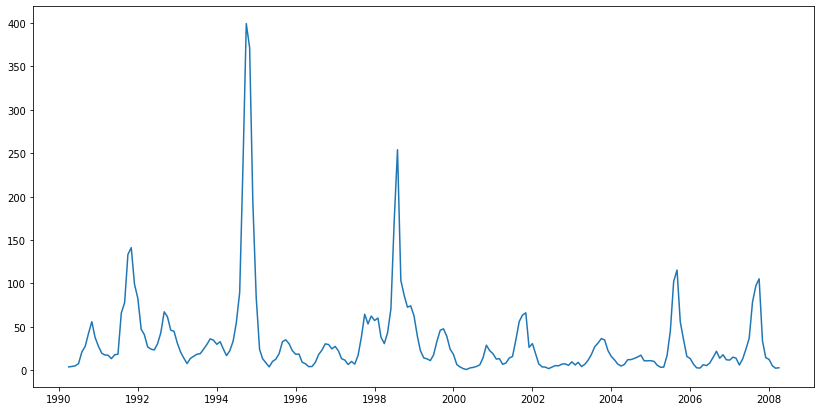

In [619]:
plt.figure(figsize=(14,7))
plt.plot(ts_data)

# Dicky Fuller Test to check for stationarity

<br>Null Hypothesis - Series is not stationary 
<br>Alternate Hypothesis - Series is stationary

If we fail to reject the null hypothesis, we can say that the series is non-stationary.

Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis, that means that series is stationary. When the test statistic is greater than the critical value, we fail to reject the null hypothesis, that means the series is not stationary).

In [742]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [743]:
#apply adf test on the series
adf_test(ts_data['total_cases'])

Results of Dickey-Fuller Test:
Test Statistic                  -5.374893
p-value                          0.000004
#Lags Used                      12.000000
Number of Observations Used    871.000000
Critical Value (1%)             -3.437880
Critical Value (5%)             -2.864864
Critical Value (10%)            -2.568540
dtype: float64


From above values we see that test statistic is less than critical values therefore we can reject null hypothesis and series is stationary

# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test - 

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null hypothesis - Series is stationary
<br>Alternative hypothesis - Series is non-stationary 

Test for stationarity: If the test statistic is greater than the critical value, we can reject the null hypothesis, that means series is not stationary. If the test statistic is less than the critical value, if fail to reject the null hypothesis, that means series is stationary.

In [738]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

In [744]:
kpss_test(ts_data['total_cases'])

Results of KPSS Test:
Test Statistic            0.394690
p-value                   0.079444
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


From above plot we can say that series test statistic is greater than critical value at 10%. We 

# Multivariate Analysis

In [146]:
ts_data = sj_data[(sj_data['year'] > 1990) & (sj_data['year'] < 2008)].reset_index(drop=True)
ts_data["week_start_date"] = dates_from_str(ts_data['week_start_date'])

In [147]:
ts_data.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

In [148]:
cols_to_keep = ['year', 
                'weekofyear',
                'week_start_date',
                'ndvi_ne',
                'ndvi_nw',
                'ndvi_se',
                'ndvi_sw', 
                'station_avg_temp_c', 
                'station_diur_temp_rng_c',
                'station_max_temp_c',
                'station_min_temp_c',
                'station_precip_mm',
                'total_cases']
ts_data = ts_data[cols_to_keep]
# removing years with missing weeks data
ts_data = ts_data[(ts_data['year']>1990) & (ts_data['year']<2008)].reset_index(drop=True)
ts_data['week_start_date'] = pd.to_datetime(ts_data['week_start_date']).dt.date
ts_data.set_index('week_start_date', inplace=True)

In [149]:
ts_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,
1991-01-01,1991,1,0.1465,0.140467,0.151500,0.167314,24.385714,7.457143,29.4,18.9,5.3,21
1991-01-08,1991,2,NaN,0.100467,0.251900,0.137617,24.914286,6.314286,28.3,21.1,31.7,21
1991-01-15,1991,3,NaN,0.293567,0.259943,0.217900,25.242857,6.571429,29.4,21.1,16.5,26
1991-01-22,1991,4,0.3313,0.309333,0.221029,0.202757,24.714286,7.771429,29.4,18.3,6.8,34
1991-01-29,1991,5,0.0917,0.246425,0.243857,0.195600,24.828571,8.157143,30.0,18.9,5.9,37


In [1025]:
# replacing missing values with median value of that column
cols_to_fix = ['ndvi_ne',
                'ndvi_nw',
                'ndvi_se',
                'ndvi_sw', 
                'station_avg_temp_c', 
                'station_diur_temp_rng_c',
                'station_max_temp_c',
                'station_min_temp_c',
                'station_precip_mm']

cols = ts_data.columns

for col in cols_to_fix:    
    print("fixing ", col)
    data_fix = ts_data.groupby('weekofyear').agg({col:'mean'}).reset_index()
    data_notnull = ts_data[ts_data[col].notnull()].copy()
    data_null = ts_data[ts_data[col].isnull()].copy()
    data_null.drop(col, axis=1,inplace=True)
    idx = data_null.index
    data_null = pd.merge(data_null, data_fix, on="weekofyear", how="left")
    data_null = data_null[cols]
    data_null.set_index(idx, inplace=True)
    data_notnull = data_notnull.append(data_null)
    ts_data = data_notnull.copy()

ts_data.sort_index(inplace=True)
ts_data.dropna(inplace=True)
ts_data.drop(['year', 'weekofyear'], axis=1, inplace=True)

fixing  ndvi_ne
fixing  ndvi_nw
fixing  ndvi_se
fixing  ndvi_sw
fixing  station_avg_temp_c
fixing  station_diur_temp_rng_c
fixing  station_max_temp_c
fixing  station_min_temp_c
fixing  station_precip_mm


In [1026]:
ts_data.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,
1991-01-01,0.146500,0.140467,0.151500,0.167314,24.385714,7.457143,29.4,18.9,5.3,21
1991-01-08,0.044869,0.100467,0.251900,0.137617,24.914286,6.314286,28.3,21.1,31.7,21
1991-01-15,0.007229,0.293567,0.259943,0.217900,25.242857,6.571429,29.4,21.1,16.5,26
1991-01-22,0.331300,0.309333,0.221029,0.202757,24.714286,7.771429,29.4,18.3,6.8,34
1991-01-29,0.091700,0.246425,0.243857,0.195600,24.828571,8.157143,30.0,18.9,5.9,37


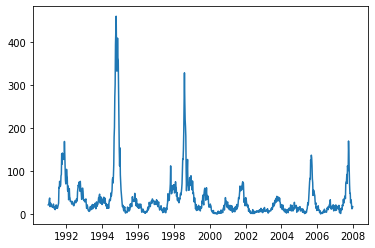

In [1027]:
plt.plot(ts_data['total_cases'])

In [1028]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
# johan_test_temp = data.drop([ 'CO(GT)'], axis=1)
coint_johansen(ts_data,-1,1).eig

array([3.83708813e-01, 3.63309309e-01, 3.28394551e-01, 3.01902228e-01,
       2.67900117e-01, 2.44731748e-01, 1.68410853e-01, 1.27819769e-01,
       3.45641131e-02, 1.13520364e-04])

Under the stationarity section, we understood that if the modulus of eigenvalues are less than 1, the series would be classified as stationary

In [1030]:
from statsmodels.tsa.base.datetools import dates_from_str
ts_data.index = dates_from_str(ts_data.index.astype(str))
ts_data.index = pd.DatetimeIndex(ts_data.index.values, freq=ts_data.index.inferred_freq)

In [1031]:
#creating the train and validation set
idx  = int(.7*len(ts_data))
train = ts_data[:idx]
valid = ts_data[idx:]

In [1032]:
train.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1991-01-01,0.146500,0.140467,0.151500,0.167314,24.385714,7.457143,29.4,18.9,5.3,21
1991-01-08,0.044869,0.100467,0.251900,0.137617,24.914286,6.314286,28.3,21.1,31.7,21
1991-01-15,0.007229,0.293567,0.259943,0.217900,25.242857,6.571429,29.4,21.1,16.5,26
1991-01-22,0.331300,0.309333,0.221029,0.202757,24.714286,7.771429,29.4,18.3,6.8,34
1991-01-29,0.091700,0.246425,0.243857,0.195600,24.828571,8.157143,30.0,18.9,5.9,37


In [1033]:
valid.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
2002-11-19,0.066233,-0.122500,0.222057,0.191386,27.214286,6.842857,32.2,23.3,30.8,6
2002-11-26,-0.005633,-0.037250,0.277329,0.290729,26.985714,7.000000,32.2,21.7,28.0,5
2002-12-03,-0.243900,-0.120933,0.279086,0.248843,26.428571,7.285714,31.1,21.7,2.9,5
2002-12-10,-0.174300,-0.072300,0.199300,0.171300,26.071429,6.642857,30.0,21.7,40.6,9
2002-12-17,-0.043000,-0.128950,0.185414,0.208800,25.928571,6.971429,30.6,21.7,18.6,3


In [1034]:
#fit the model
from statsmodels.tsa.api import VAR

model = VAR(endog=train)
model_fit = model.fit()



In [1042]:
# make prediction on validation
prediction = model_fit.forecast(y=train.values, steps=len(valid))
prediction

array([[ 0.04492311,  0.07854948,  0.19757565, ..., 22.69512858,
        21.1896895 , 14.4943535 ],
       [ 0.06755323,  0.08463083,  0.17870192, ..., 22.82954485,
        24.13852847, 15.22222921],
       [ 0.07281664,  0.0882698 ,  0.17756483, ..., 22.85982598,
        25.97929017, 16.48556558],
       ...,
       [ 0.07431645,  0.08905341,  0.17928161, ..., 22.61392046,
        25.31917086, 42.03531526],
       [ 0.07431645,  0.08905341,  0.17928161, ..., 22.61392046,
        25.31917085, 42.03531553],
       [ 0.07431645,  0.08905341,  0.17928161, ..., 22.61392046,
        25.31917084, 42.03531578]])

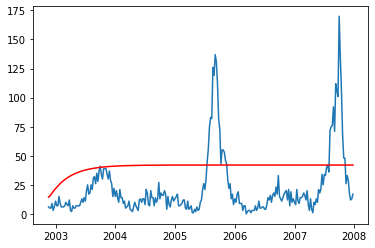

In [1043]:
plt.plot(valid["total_cases"])
plt.plot(valid.index, prediction[:,-1], color='red')

# Linear Regression Model

In [420]:
def preprocess_data(data):
    
    data = data.copy()
    data.drop(['city', 'year', 'week_start_date'], axis=1, inplace=True)
    cols_median = data.median()
    for j in range(len(cols_median)):
        data.iloc[:,j].fillna(cols_median[j], inplace=True)
    
#     data = pd.concat([data, pd.get_dummies(data['weekofyear'], prefix='week_')], axis=1)
#     data.drop('weekofyear', axis=1, inplace=True)
    
    features_list = [feature for feature in data.columns if feature != target] 
    data = data[features_list+[target]]
    train_data, test_data = train_test_split(data, test_size=0.25, random_state = 1)
    
    X_train = train_data[features_list].values
    X_test = test_data[features_list].values
    
    y_train = train_data[target].values
    y_test = test_data[target].values
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
 
    return X_train, y_train, X_test, y_test, features_list, scaler

In [473]:
def preprocess_data(data):
    
    data = data.copy()
    cols_to_delete = ['city', 
                      'year', 
                      'week_start_date',
                      'precipitation_amt_mm',
                      'station_avg_temp_c',
                      'station_diur_temp_rng_c',
                      'station_max_temp_c',
                      'station_min_temp_c',
                      'station_precip_mm',
#                       'reanalysis_air_temp_k', 
#                       'reanalysis_avg_temp_k',
#                       'reanalysis_dew_point_temp_k',
#                       'reanalysis_max_air_temp_k',
#                       'reanalysis_min_air_temp_k',
#                       'reanalysis_precip_amt_kg_per_m2',
#                       'reanalysis_relative_humidity_percent',
#                       'reanalysis_sat_precip_amt_mm',
#                       'reanalysis_specific_humidity_g_per_kg',
#                       'reanalysis_tdtr_k'
                     ]
    data.drop(cols_to_delete, axis=1, inplace=True)
    cols_median = data.median()
    for j in range(len(cols_median)):
        data.iloc[:,j].fillna(cols_median[j], inplace=True)
    
    data = pd.concat([data, pd.get_dummies(data['weekofyear'], prefix='week_')], axis=1)
    data.drop('weekofyear', axis=1, inplace=True)
    
    features_list = [feature for feature in data.columns if feature != target] 
    data = data[features_list+[target]]
    train_data, test_data = train_test_split(data, test_size=0.25, random_state = 1)
        
    train_data = train_data.values
    test_data = test_data.values
    
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    
    
    X_train = train_data[:,:len(features_list)]
    X_test = test_data[:,:len(features_list)]
    
    y_train = train_data[:,-1]
    y_test = test_data[:,-1]
    
    return X_train, y_train, X_test, y_test, features_list, scaler

In [474]:
X_train, y_train, X_test, y_test, features_list, scaler  = preprocess_data(data=sj_data)

In [476]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((702, 67), (702,), (234, 67), (234,))

In [477]:
from sklearn.linear_model import LinearRegression

In [478]:
lr = LinearRegression()
lr = lr.fit(X=X_train, y=y_train)

In [479]:
mean_squared_error(y_true=y_train, y_pred=lr.predict(X=X_train))

0.7874973868844247

In [480]:
mean_squared_error(y_true=y_test, y_pred=lr.predict(X=X_test))

0.95979598724795

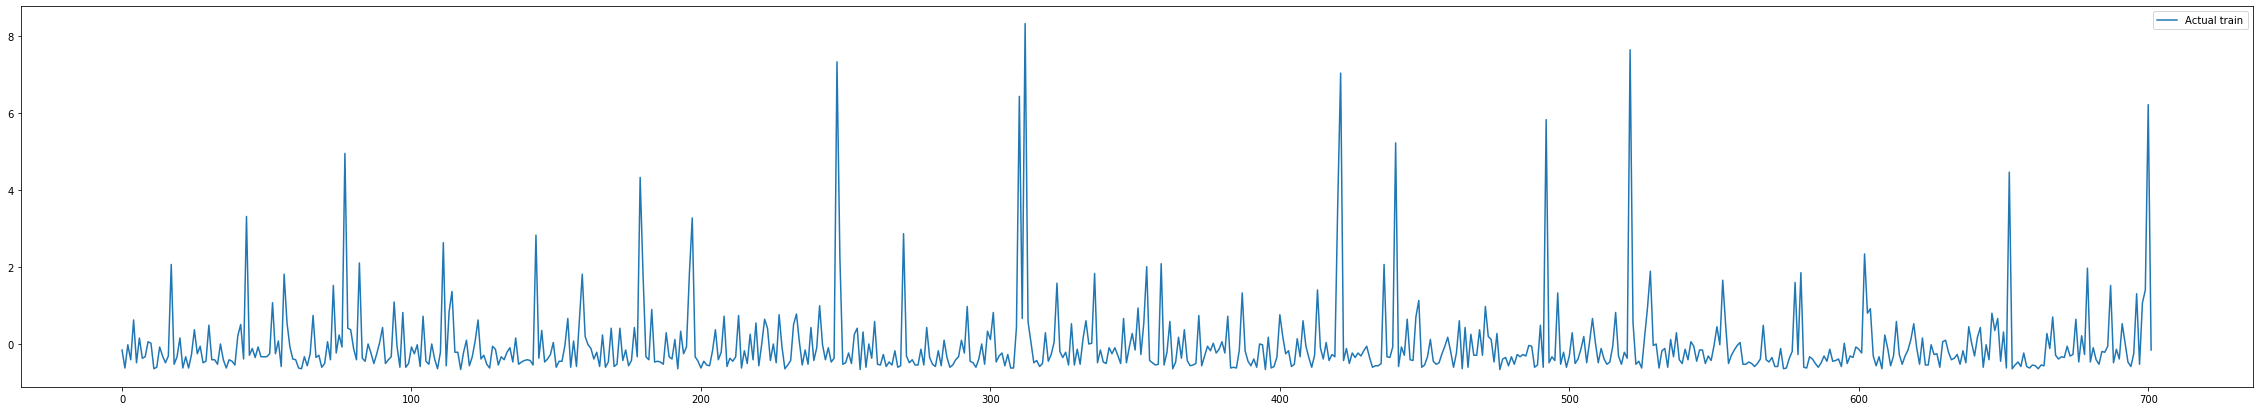

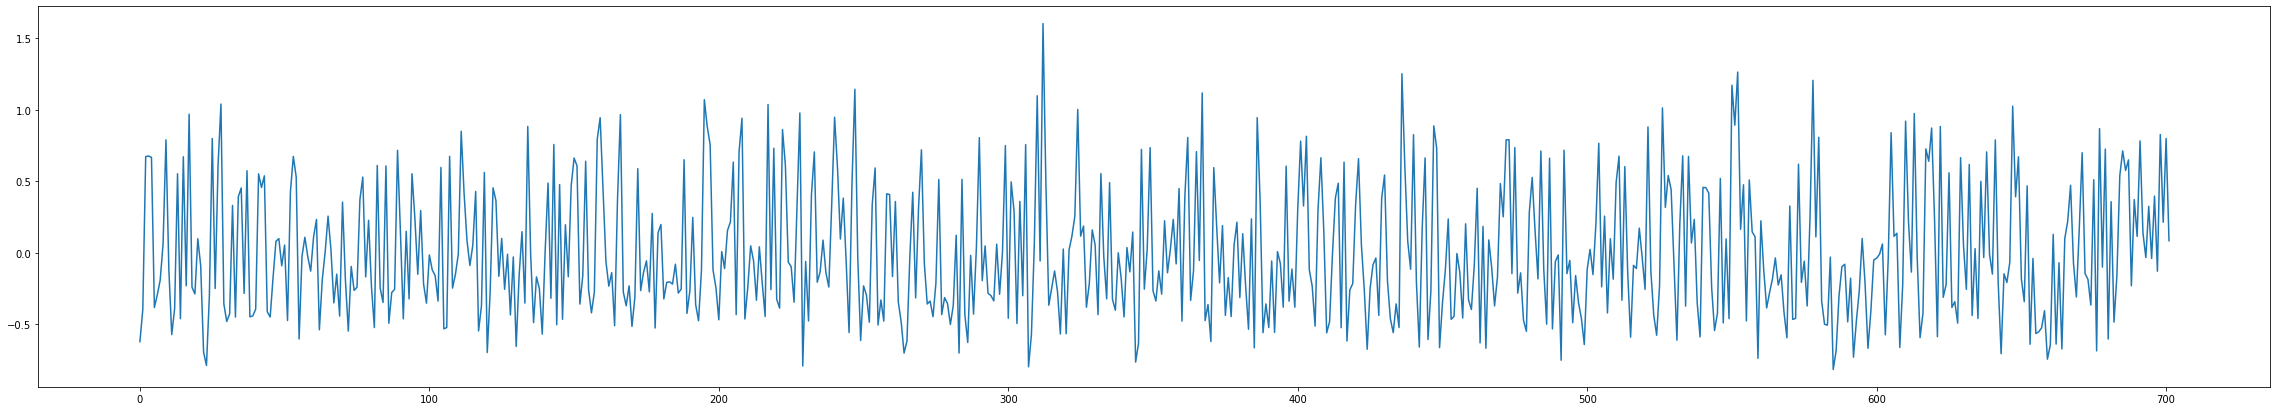

In [482]:
fig = plt.figure(figsize=(40,7))
len_train = [i for i in range(len(X_train))] 
plt.plot(len_train, y_train, label = "Actual train")
plt.legend()
fig = plt.figure(figsize=(40,7))
plt.plot(len_train, y_train_predict, label = "Predicted train")

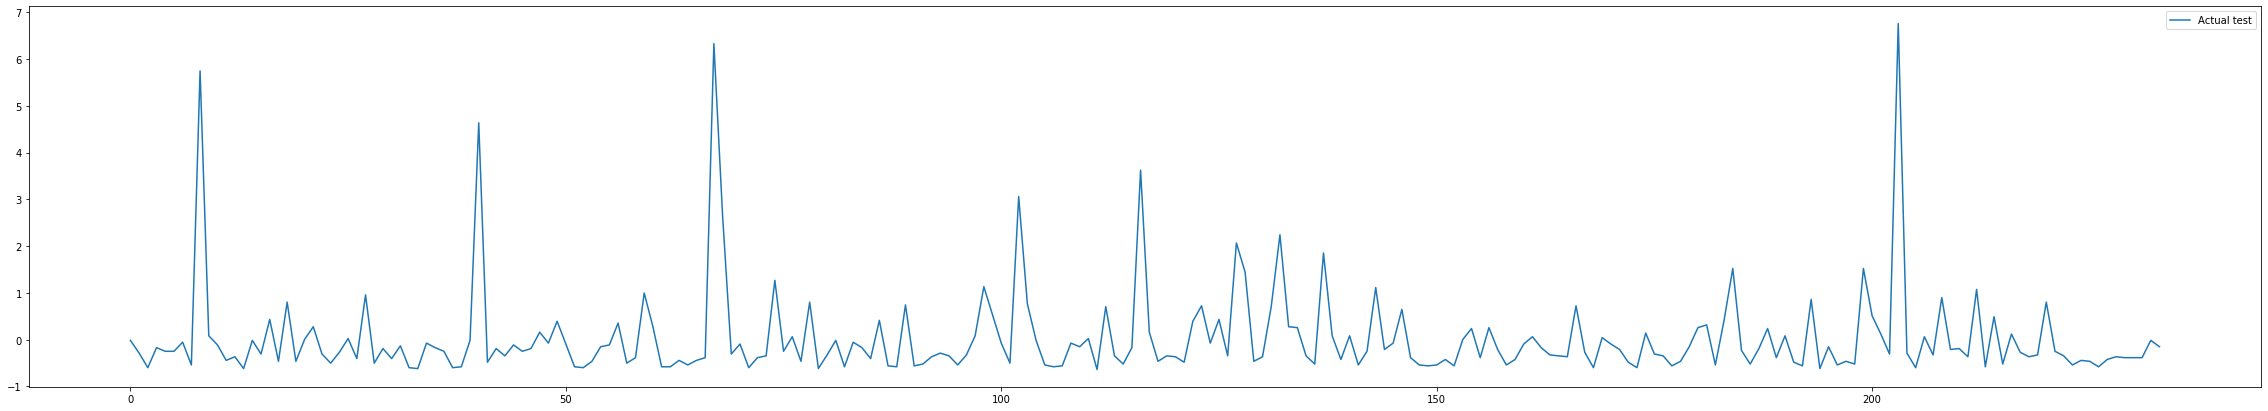

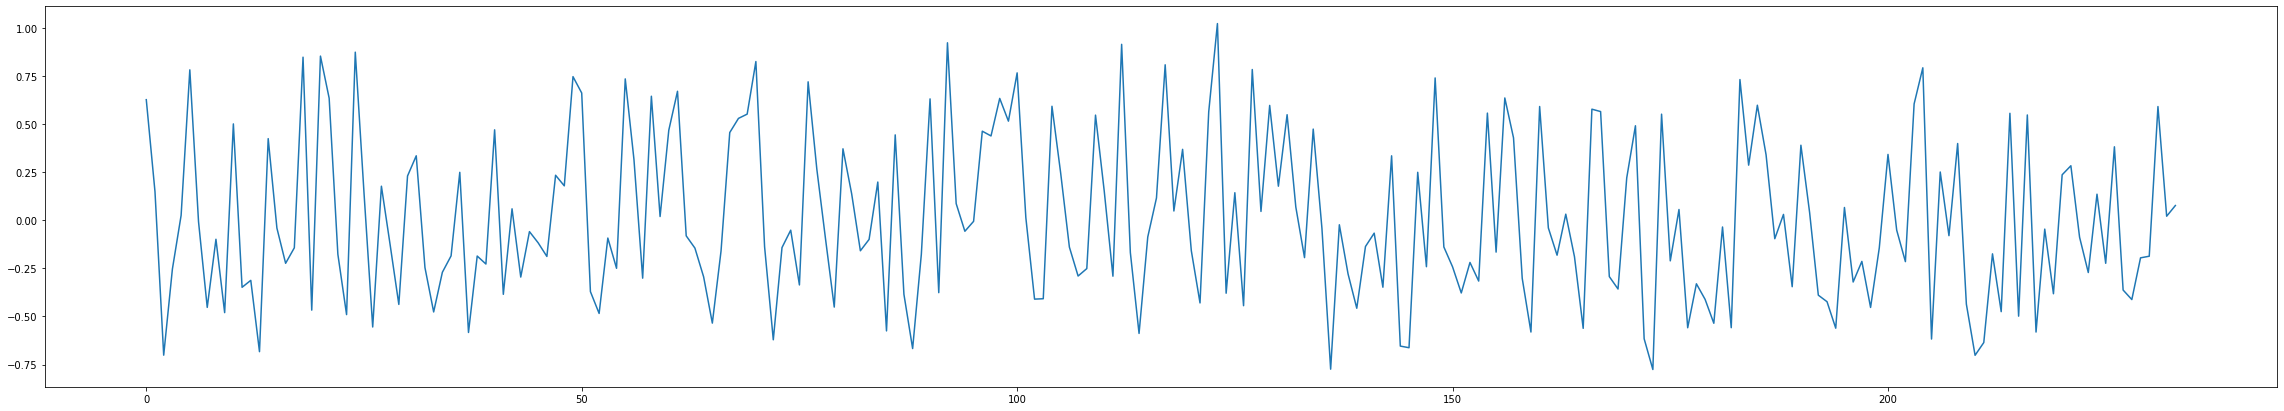

In [462]:
fig = plt.figure(figsize=(40,7))
len_test = [i for i in range(len(X_test))] 
plt.plot(len_test, y_test, label = "Actual test")
plt.legend()
fig = plt.figure(figsize=(40,7))
plt.plot(len_test, y_test_predict, label = "Predicted test")